In [1]:
# 导入库
import numpy as np
import pandas as pd
from time import time
from IPython.display import display
import pandas_profiling

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
# 导入数据
data_train = pd.read_csv("train.csv")
data_store = pd.read_csv("store.csv")
data_test = pd.read_csv("test.csv")

# 显示第一条记录
display(data_train.head())

C:\Users\taili\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [3]:
#交易数据可视化
data_train.profile_report(style={'full_width':True})

In [4]:
#商店数据可视化
data_store.profile_report(style={'full_width':True})

In [5]:
#Null值处理
data_store.fillna(0,inplace=True)
data_test.fillna(1, inplace=True)

In [6]:
#确定Null值处理完毕
display(data_train.isnull().sum(),data_train.isnull().sum(),data_store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [7]:
#查看字段类型，确定字段类型能够导入模型
display(data_train.dtypes,data_test.dtypes)

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

Id                 int64
Store              int64
DayOfWeek          int64
Date              object
Open             float64
Promo              int64
StateHoliday      object
SchoolHoliday      int64
dtype: object

In [8]:
#日期格式转换
data_train['Date'] = pd.to_datetime(data_train['Date'])
data_test['Date'] = pd.to_datetime(data_test['Date'])

In [9]:
#交易数据集与商店数据集合并
train = pd.merge(data_train, data_store, on='Store')
test = pd.merge(data_test, data_store, on='Store')
train = train.sort_values(['Date'],ascending = False)

In [10]:
#由于本项目是预测未来6周销售额，因此在拆分验证集时，也按未来6周进行拆分
#交易数据集中共有1115家商店，按照日期排序后，1115家未来6周的销售数据应为最后1115*7*6行
#训练集与测试集切片
#参考https://www.kaggle.com/c/rossmann-store-sales/discussion/18024

tai_test = train[:6*7*1115]
tai_train = train[6*7*1115:]

In [11]:
#未营业的商店不产生销量，属于噪音数据，应剔除
tai_test = tai_test[(tai_test["Open"] != 0)&(tai_test["Sales"] > 0)]
tai_train = tai_train[(tai_train["Open"] != 0)&(tai_train["Sales"] > 0)]

In [12]:
#创建特征处理函数

def features_handle(data):
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #替换完成后进行类型转化
    data['StateHoliday'] = data['StateHoliday'].astype('int')
    data['Assortment'] = data['Assortment'].astype('int')
    data['StoreType'] = data['StoreType'].astype('int')
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
  
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['month_str'] = data.Month.map(month2str)
    def check(row):
        if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
            return 1
        else:
            return 0
        
    data['IsPromoMonth'] =  data.apply(lambda row: check(row),axis=1)

    return data

In [13]:
#特征批量处理
features_handle(tai_train)
features_handle(tai_test)
features_handle(test)

Id  Store  DayOfWeek       Date  Open  Promo  StateHoliday  \
0          1      1          3 2015-09-17   1.0      1             0   
1        857      1          2 2015-09-16   1.0      1             0   
2       1713      1          1 2015-09-15   1.0      1             0   
3       2569      1          0 2015-09-14   1.0      1             0   
4       3425      1          6 2015-09-13   0.0      0             0   
...      ...    ...        ...        ...   ...    ...           ...   
41083  37664   1115          2 2015-08-05   1.0      1             0   
41084  38520   1115          1 2015-08-04   1.0      1             0   
41085  39376   1115          0 2015-08-03   1.0      1             0   
41086  40232   1115          6 2015-08-02   0.0      0             0   
41087  41088   1115          5 2015-08-01   1.0      0             0   

       SchoolHoliday  StoreType  Assortment  ...  Promo2SinceYear  \
0                  0          3           1  ...              0.0   
1                  0          3           1  ...              0.0   
2                  0          3           1  ...              0.0   
3                  0          3           1  ...              0.0   
4                  0          3           1  ...              0.0   
...              ...        ...         ...  ...              ...   
41083              1          4           3  ...           2012.0   
41084              1          4           3  ...           2012.0   
41085              1          4           3  ...           2012.0   
41086              1          4           3  ...           2012.0   
41087              1          4           3  ...           2012.0   

          PromoInterval  Year  Month  Day  WeekOfYear CompetitionOpen  \
0                     0  2015      9   17          38            84.0   
1                     0  2015      9   16          38            84.0   
2                     0  2015      9   15          38            84.0   
3                     0  2015      9   14          38            84.0   
4                     0  2015      9   13          37            84.0   
...                 ...   ...    ...  ...         ...             ...   
41083  Mar,Jun,Sept,Dec  2015      8    5          32         24188.0   
41084  Mar,Jun,Sept,Dec  2015      8    4          32         24188.0   
41085  Mar,Jun,Sept,Dec  2015      8    3          32         24188.0   
41086  Mar,Jun,Sept,Dec  2015      8    2          31         24188.0   
41087  Mar,Jun,Sept,Dec  2015      8    1          31         24188.0   

       PromoOpen  month_str  IsPromoMonth  
0       24189.50       Sept             0  
1       24189.50       Sept             0  
2       24189.50       Sept             0  
3       24189.50       Sept             0  
4       24189.25       Sept             0  
...          ...        ...           ...  
41083      38.50        Aug             0  
41084      38.50        Aug             0  
41085      38.50        Aug             0  
41086      38.25        Aug             0  
41087      38.25        Aug             0  

[41088 rows x 25 columns]

In [14]:
#丢弃不需要特征
drop_list = ['Date','Customers','Open','PromoInterval','month_str']
tai_train.drop(drop_list,axis=1,inplace =True)
tai_test.drop(drop_list,axis=1,inplace =True)

In [15]:
#生成XGboost训练集与验证集,将销量转化为正态分布
tai_xtrain = tai_train.drop(['Sales'],axis=1 )
tai_ytrain = np.log1p(tai_train.Sales)
tai_xtest = tai_test.drop(['Sales'],axis=1 )
tai_ytest = np.log1p(tai_test.Sales)

In [16]:
#测试集丢弃无用信息
xtest =test.drop(['Date','Id','Open','PromoInterval','month_str'],axis = 1)

In [17]:
#定义评估函数
def rmspe(y_true, y_pred):
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))
    return loss

#XGBoost评估函数输入参数反向
def rmspe_xg(y_pred, y_true):
    return "rmspe", rmspe(np.expm1(y_true.get_label()),np.expm1(y_pred))

In [18]:
import xgboost as xgb
#XGboost参数设置
params = {"objective": "reg:squarederror",
          'learning_rate':0.1,
          "booster" : "gbtree",
          "max_depth": 10,
          "min_child_weight":1,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "gamma":0.8,
          "silent": 1,
          "seed": 10,
          "tree_method":"gpu_hist",
          "gpu_id":0
          }
num_boost_round = 10000

/opt/anaconda3/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/opt/anaconda3/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))


In [19]:
#XGboost训练集与验证集
dtrain = xgb.DMatrix(tai_xtrain, tai_ytrain)
dvalid = xgb.DMatrix(tai_xtest, tai_ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [20]:
#得到序列
from itertools import combinations

def grid_dict(param_test):
    combine_list = []
    key_nums = 0
    for i in param_test:
        key_nums += 1
        for j in param_test[i]:
            combine_list.append({i:j})
  
    result = []
    for i in combinations(combine_list, key_nums):
        tmp_dict = {}
        for j in list(i):
            for key in j:
                tmp_dict[key] = j[key]
        if len(tmp_dict) == key_nums:
            result.append(tmp_dict)
    
    return result

def train_model(params,flag = False):
    print("Start Train...")
    start = time()
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=flag)
    end = time()
    print('time is {:2f} s.'.format(end-start))
    
    print("testing...")
    tai_xtest.sort_index(inplace=True) 
    tai_ytest.sort_index(inplace=True) 
    yhat = gbm.predict(xgb.DMatrix(tai_xtest))
    error = rmspe(np.expm1(tai_ytest), np.expm1(yhat))

    print('RMSPE: {:.6f}'.format(error))
    return error,gbm

def grid_search_xg(params, params_grid):
    iter_num = 1
    grid_list = grid_dict(params_grid)
    gbm = None
    print('Iter nums is {:1f}.'.format(len(grid_list)))
    min_error = 100
    result_params = {}
    for i in grid_list:
        print('Iter No is {:1f}.'.format(iter_num))
        for key in i:
            params[key] = i[key]
        print(params)
        model_result = train_model(params)
        error = model_result[0]
        if error<min_error:
            result_params = i
            min_error = error
            gbm = model_result[1]
        iter_num += 1
    
    print('best_param:')
    print(result_params)
    
    for key in result_params:
        params[key] = result_params[key]
    return gbm     

In [21]:
#基础模型
train_model(params, True)

Start Train...
[0]	train-rmse:7.44339	eval-rmse:7.44802	train-rmspe:0.999525	eval-rmspe:0.999529
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:6.70073	eval-rmse:6.70588	train-rmspe:0.998819	eval-rmspe:0.998831
[2]	train-rmse:6.03246	eval-rmse:6.03885	train-rmspe:0.997546	eval-rmspe:0.997573
[3]	train-rmse:5.43112	eval-rmse:5.43819	train-rmspe:0.995402	eval-rmspe:0.995456
[4]	train-rmse:4.89	eval-rmse:4.8971	train-rmspe:0.992009	eval-rmspe:0.9921
[5]	train-rmse:4.40333	eval-rmse:4.40933	train-rmspe:0.986928	eval-rmspe:0.987058
[6]	train-rmse:3.96545	eval-rmse:3.97187	train-rmspe:0.979703	eval-rmspe:0.979911
[7]	train-rmse:3.57151	eval-rmse:3.57849	train-rmspe:0.969898	eval-rmspe:0.970218
[8]	train-rmse:3.21724	eval-rmse:3.22288	train-rmspe:0.957106	eval-rmspe:0.957485
[9]	train-rmse:2.89841	eval-rmse:2.90432	train-rmspe:0.941098	eval-rmspe:0.941629
[10]	train-rmse:2.61181	e

(0.1359877838865994, <xgboost.core.Booster at 0x7f6e118c0828>)

In [22]:
#调试max_depth和min_child_weight
param_grid = {'max_depth':range(9,13,1), 'min_child_weight':range(1,5,1)}

In [23]:
grid_search_xg(params, param_grid)

Iter nums is 16.000000.
Iter No is 1.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'booster': 'gbtree', 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.7, 'gamma': 0.8, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0}
Start Train...
time is 85.288815 s.
testing...
RMSPE: 0.134574
Iter No is 2.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'booster': 'gbtree', 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9, 'colsample_bytree': 0.7, 'gamma': 0.8, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0}
Start Train...
time is 81.963518 s.
testing...
RMSPE: 0.135784
Iter No is 3.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'booster': 'gbtree', 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9, 'colsample_bytree': 0.7, 'gamma': 0.8, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0}
Start Train...
time is 75.317345 s.
testing...
RMSPE: 0.135562
Iter No is

In [24]:
#调试Gamma
param_grid = {'gamma':[i/10.0 for i in range(0,10,2)]}

In [25]:
grid_search_xg(params, param_grid)

Iter nums is 5.000000.
Iter No is 1.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'booster': 'gbtree', 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9, 'colsample_bytree': 0.7, 'gamma': 0.0, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0}
Start Train...
time is 77.590029 s.
testing...
RMSPE: 0.130452
Iter No is 2.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'booster': 'gbtree', 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9, 'colsample_bytree': 0.7, 'gamma': 0.2, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0}
Start Train...
time is 77.265997 s.
testing...
RMSPE: 0.130452
Iter No is 3.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'booster': 'gbtree', 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9, 'colsample_bytree': 0.7, 'gamma': 0.4, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0}
Start Train...
time is 77.079501 s.
testing...
RMSPE: 0.130452
Iter No 

In [26]:
#调试subsample与colsample_bytree
param_grid = {'subsample':[i/100.0 for i in range(75,96,5)],'colsample_bytree':[i/100.0 for i in range(75,96,5)]}

In [27]:
grid_search_xg(params, param_grid)

Iter nums is 25.000000.
Iter No is 1.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'booster': 'gbtree', 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.75, 'colsample_bytree': 0.75, 'gamma': 0.0, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0}
Start Train...
time is 69.150906 s.
testing...
RMSPE: 0.134699
Iter No is 2.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'booster': 'gbtree', 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.75, 'colsample_bytree': 0.8, 'gamma': 0.0, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0}
Start Train...
time is 87.034037 s.
testing...
RMSPE: 0.137808
Iter No is 3.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'booster': 'gbtree', 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.75, 'colsample_bytree': 0.85, 'gamma': 0.0, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0}
Start Train...
time is 58.874049 s.
testing...
RMSPE: 0.139986
It

In [28]:
#调试reg_alpha
param_grid = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

In [29]:
grid_search_xg(params, param_grid)

Iter nums is 5.000000.
Iter No is 1.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'booster': 'gbtree', 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.85, 'colsample_bytree': 0.85, 'gamma': 0.0, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0, 'reg_alpha': 1e-05}
Start Train...
time is 72.526450 s.
testing...
RMSPE: 0.128054
Iter No is 2.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'booster': 'gbtree', 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.85, 'colsample_bytree': 0.85, 'gamma': 0.0, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0, 'reg_alpha': 0.01}
Start Train...
time is 63.176467 s.
testing...
RMSPE: 0.130097
Iter No is 3.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'booster': 'gbtree', 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.85, 'colsample_bytree': 0.85, 'gamma': 0.0, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0, 'reg_alpha': 0.1}
Start Tr

In [30]:
#调试reg_lambda
param_grid = {'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]}

In [31]:
grid_search_xg(params, param_grid)

Iter nums is 5.000000.
Iter No is 1.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'booster': 'gbtree', 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.85, 'colsample_bytree': 0.85, 'gamma': 0.0, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05}
Start Train...
time is 61.677102 s.
testing...
RMSPE: 0.139669
Iter No is 2.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'booster': 'gbtree', 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.85, 'colsample_bytree': 0.85, 'gamma': 0.0, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0, 'reg_alpha': 1e-05, 'reg_lambda': 0.01}
Start Train...
time is 54.217977 s.
testing...
RMSPE: 0.136544
Iter No is 3.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'booster': 'gbtree', 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.85, 'colsample_bytree': 0.85, 'gamma': 0.0, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist

In [32]:
#调试learning_rate
param_grid = {'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2]}

In [33]:
#最终模型
gbm = grid_search_xg(params, param_grid)

Iter nums is 6.000000.
Iter No is 1.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.01, 'booster': 'gbtree', 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.85, 'colsample_bytree': 0.85, 'gamma': 0.0, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0, 'reg_alpha': 1e-05, 'reg_lambda': 100}
Start Train...
time is 730.550876 s.
testing...
RMSPE: 0.125853
Iter No is 2.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.03, 'booster': 'gbtree', 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.85, 'colsample_bytree': 0.85, 'gamma': 0.0, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0, 'reg_alpha': 1e-05, 'reg_lambda': 100}
Start Train...
time is 334.422142 s.
testing...
RMSPE: 0.129619
Iter No is 3.000000.
{'objective': 'reg:squarederror', 'learning_rate': 0.05, 'booster': 'gbtree', 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.85, 'colsample_bytree': 0.85, 'gamma': 0.0, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hi

In [34]:
#最终参数
print(params)

{'objective': 'reg:squarederror', 'learning_rate': 0.1, 'booster': 'gbtree', 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.85, 'colsample_bytree': 0.85, 'gamma': 0.0, 'silent': 1, 'seed': 10, 'tree_method': 'gpu_hist', 'gpu_id': 0, 'reg_alpha': 1e-05, 'reg_lambda': 100}


In [35]:
#保存模型
gbm.save_model('best_xg.model')

In [72]:
#第一次预测
print("First predictions on the valid set")
dtest = xgb.DMatrix(xtest)
test_probs = gbm.predict(dtest)

First predictions on the valid set


In [73]:
#导出第一次预测结果
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs)})
result.to_csv("Rossmann_submission.csv", index=False)

In [74]:
#在验证集上测试，并生成结果
tai_xtest.sort_index(inplace=True) 
tai_ytest.sort_index(inplace=True) 
y_pred = gbm.predict(xgb.DMatrix(tai_xtest))
error = rmspe(np.expm1(tai_ytest), np.expm1(y_pre))

print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.125729


In [68]:
#合并预测结果
res = pd.DataFrame(data = tai_ytest)
res['Prediction']=y_pred
res = pd.merge(tai_xtest,res, left_index= True, right_index=True)
res['Ratio'] = res.Prediction/res.Sales
res['Error'] =abs(res.Ratio-1)
res['Weight'] = res.Sales/res.Prediction
res.head()

Store  DayOfWeek  Promo  StateHoliday  SchoolHoliday  StoreType  \
0      1          4      1             0              1          3   
1      1          3      1             0              1          3   
2      1          2      1             0              1          3   
3      1          1      1             0              1          3   
4      1          0      1             0              1          3   

   Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0           1               1270.0                        9.0   
1           1               1270.0                        9.0   
2           1               1270.0                        9.0   
3           1               1270.0                        9.0   
4           1               1270.0                        9.0   

   CompetitionOpenSinceYear  ...  Day  WeekOfYear  CompetitionOpen  PromoOpen  \
0                    2008.0  ...   31          31             82.0   24187.75   
1                    2008.0  ...   30          31             82.0   24187.75   
2                    2008.0  ...   29          31             82.0   24187.75   
3                    2008.0  ...   28          31             82.0   24187.75   
4                    2008.0  ...   27          31             82.0   24187.75   

   IsPromoMonth     Sales  Prediction     Ratio     Error    Weight  
0             0  8.568646    8.666219  1.011387  0.011387  0.988741  
1             0  8.521384    8.584636  1.007423  0.007423  0.992632  
2             0  8.472823    8.468044  0.999436  0.000564  1.000564  
3             0  8.519590    8.461063  0.993130  0.006870  1.006917  
4             0  8.716536    8.617434  0.988631  0.011369  1.011500  

[5 rows x 25 columns]

In [69]:
#预测结果可视化
col_1 = ['Sales','Prediction']
col_2 = ['Ratio']

预测与实际销售额比率 1.002060709979988: 整体
平均预测与实际销售额比率 1.0050264098202792: store 212
平均预测与实际销售额比率 1.0004637044073093: store 233
平均预测与实际销售额比率 1.0028789668620643: store 515
平均预测与实际销售额比率 0.9954761081691448: store 4


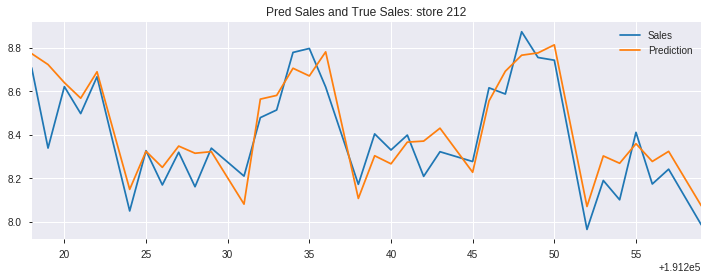

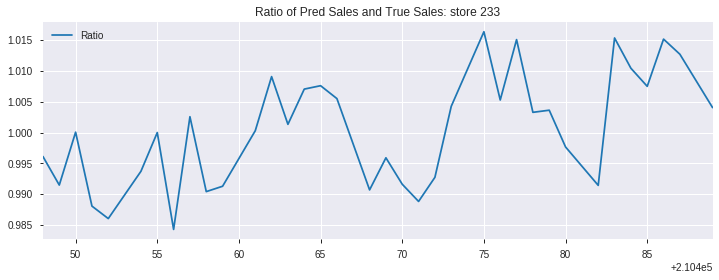

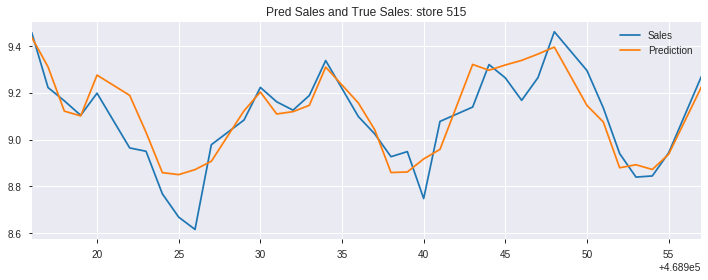

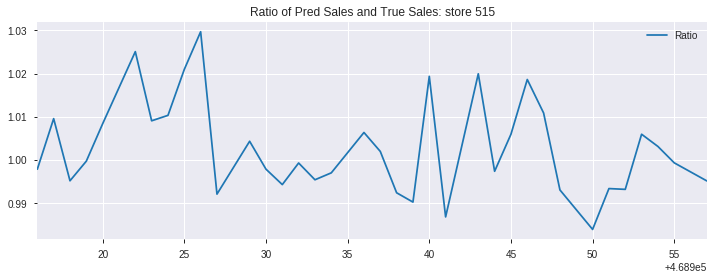

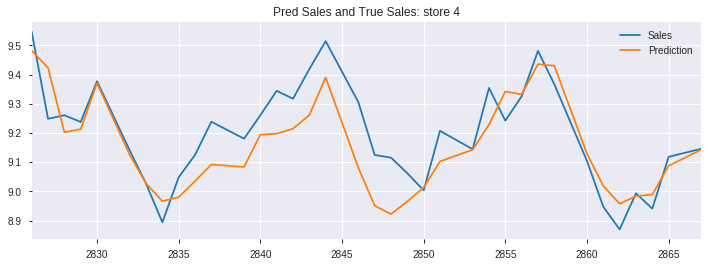

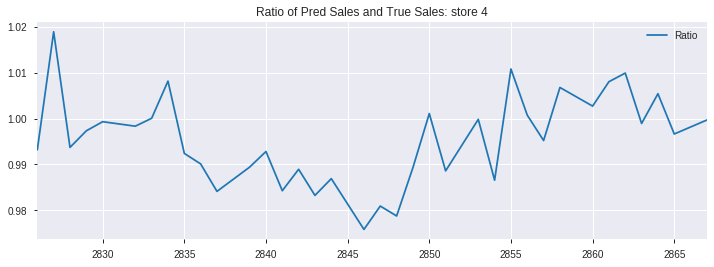

In [70]:
#随机抽取四个商店，与预测值进行比较
L=np.random.randint(low=1,high = 1115, size = 4 ) 
print('预测与实际销售额比率 {}: 整体'.format(res.Ratio.mean()))
for i in L:
    s1 = pd.DataFrame(res[res['Store']==i],columns = col_1)
    s2 = pd.DataFrame(res[res['Store']==i],columns = col_2)
    s1.plot(title = 'Pred Sales and True Sales: store {}'.format(i),figsize=(12,4))
    s2.plot(title = 'Ratio of Pred Sales and True Sales: store {}'.format(i),figsize=(12,4))
    print('平均预测与实际销售额比率 {}: store {}'.format(s2.Ratio.mean(),i))

In [52]:
#选取错误率排名后10位
res.sort_values(['Error'],ascending=False,inplace= True)
res[:10]['Weight'].describe()

count    10.000000
mean      1.003808
std       0.153365
min       0.810213
25%       0.862668
50%       1.016062
75%       1.133814
max       1.168643
Name: Weight, dtype: float64

RMSPE for 0.860:0.701425
RMSPE for 0.861:0.698809
RMSPE for 0.862:0.696170
RMSPE for 0.863:0.693508
RMSPE for 0.864:0.690823
RMSPE for 0.865:0.688115
RMSPE for 0.866:0.685383
RMSPE for 0.867:0.682628
RMSPE for 0.868:0.679848
RMSPE for 0.869:0.677044
RMSPE for 0.870:0.674216
RMSPE for 0.871:0.671364
RMSPE for 0.872:0.668486
RMSPE for 0.873:0.665584
RMSPE for 0.874:0.662657
RMSPE for 0.875:0.659704
RMSPE for 0.876:0.656725
RMSPE for 0.877:0.653721
RMSPE for 0.878:0.650691
RMSPE for 0.879:0.647634
RMSPE for 0.880:0.644551
RMSPE for 0.881:0.641442
RMSPE for 0.882:0.638305
RMSPE for 0.883:0.635141
RMSPE for 0.884:0.631950
RMSPE for 0.885:0.628732
RMSPE for 0.886:0.625486
RMSPE for 0.887:0.622211
RMSPE for 0.888:0.618909
RMSPE for 0.889:0.615578
RMSPE for 0.890:0.612218
RMSPE for 0.891:0.608830
RMSPE for 0.892:0.605412
RMSPE for 0.893:0.601965
RMSPE for 0.894:0.598489
RMSPE for 0.895:0.594982
RMSPE for 0.896:0.591446
RMSPE for 0.897:0.587879
RMSPE for 0.898:0.584282
RMSPE for 0.899:0.580653


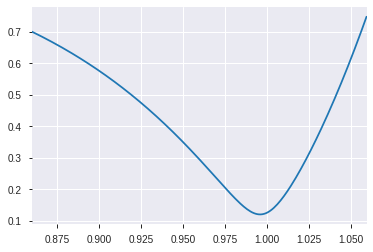

In [58]:
# 数据整体修正权重确定
# 确定修正权重范围
W=[(0.860+(i/1000)) for i in range(200)]
#W=[(0.860+(i/1000)) for i in range(200)]
S =[]
for w in W:
    error = rmspe(np.expm1(tai_ytest), np.expm1(y_pred*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
best_weight = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(best_weight))

In [59]:
#商店维度进行权重修正
M=range(1115)
W_ho=[]
W_test=[]
for i in M:
    s1 = pd.DataFrame(res[res['Store']==i+1],columns = col_1)
    s2 = pd.DataFrame(xtest[xtest['Store']==i+1])
    #W1=[(0.990+(i/1000)) for i in range(20)]
    W1=[(0.860+(i/1000)) for i in range(200)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
        S.append(error)
    Score = pd.Series(S,index=W1)
    BS = Score[Score.values == Score.values.min()]
    a=np.array(BS.index.values)
    b_ho=a.repeat(len(s1))
    b_test=a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    W_test.extend(b_test.tolist())

In [61]:
#修正后的预测值
yhat_new = y_pred*W_ho
error = rmspe(np.expm1(tai_ytest), np.expm1(yhat_new))
print ('RMSPE for weight corretion {:6f}'.format(error))

RMSPE for weight corretion 0.110299


In [62]:
# 最终修正后结果
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs*W_test)})
result.to_csv("Rossmann_submission_final.csv", index=False)

In [63]:
#合并预测结果
res2 = pd.DataFrame(data = tai_ytest)
res2['Prediction'] = yhat_new
res2 = pd.merge(tai_xtest,res2, left_index= True, right_index=True)
res2['Ratio'] = res2.Prediction/res2.Sales
res2['Error'] =abs(res2.Ratio-1)
res2['Weight'] = res2.Sales/res2.Prediction
res2.head()

Store  DayOfWeek  Promo  StateHoliday  SchoolHoliday  StoreType  \
0      1          4      1             0              1          3   
1      1          3      1             0              1          3   
2      1          2      1             0              1          3   
3      1          1      1             0              1          3   
4      1          0      1             0              1          3   

   Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0           1               1270.0                        9.0   
1           1               1270.0                        9.0   
2           1               1270.0                        9.0   
3           1               1270.0                        9.0   
4           1               1270.0                        9.0   

   CompetitionOpenSinceYear  ...  Day  WeekOfYear  CompetitionOpen  PromoOpen  \
0                    2008.0  ...   31          31             82.0   24187.75   
1                    2008.0  ...   30          31             82.0   24187.75   
2                    2008.0  ...   29          31             82.0   24187.75   
3                    2008.0  ...   28          31             82.0   24187.75   
4                    2008.0  ...   27          31             82.0   24187.75   

   IsPromoMonth     Sales  Prediction     Ratio     Error    Weight  
0             0  8.568646    8.640220  1.008353  0.008353  0.991716  
1             0  8.521384    8.558882  1.004400  0.004400  0.995619  
2             0  8.472823    8.442640  0.996438  0.003562  1.003575  
3             0  8.519590    8.435680  0.990151  0.009849  1.009947  
4             0  8.716536    8.591581  0.985665  0.014335  1.014544  

[5 rows x 25 columns]

预测与实际销售额比率 1.002060709979988: 整体
平均预测与实际销售额比率 0.9979912249515375: store 212
平均预测与实际销售额比率 0.998462776998495: store 233
平均预测与实际销售额比率 0.9988674509946167: store 515
平均预测与实际销售额比率 0.9984625364936522: store 4


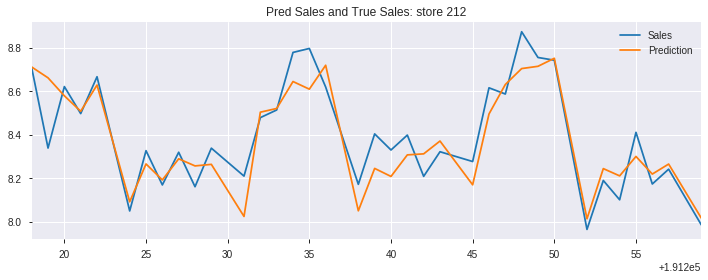

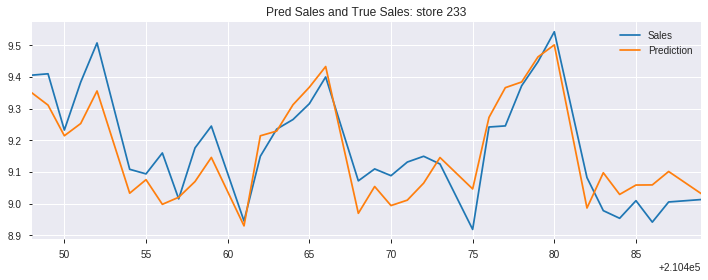

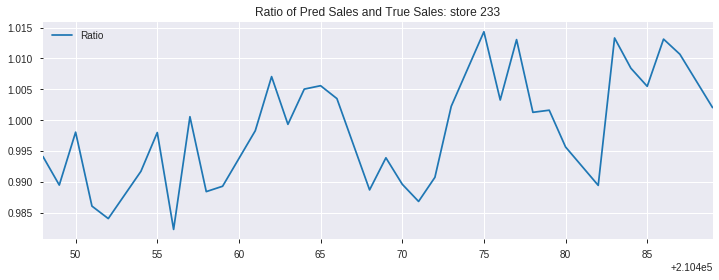

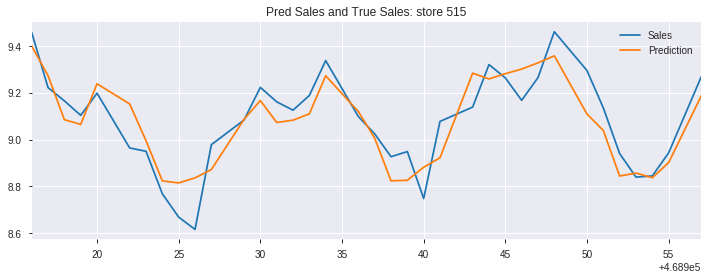

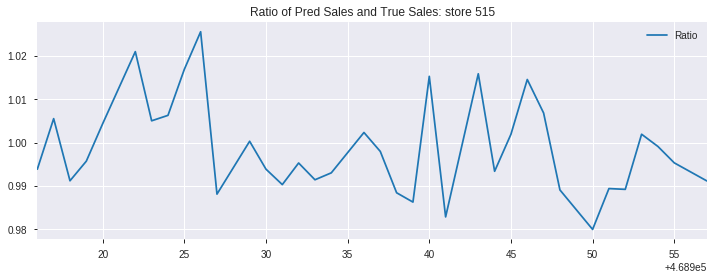

In [71]:
# 预测结果可视化
print('预测与实际销售额比率 {}: 整体'.format(res.Ratio.mean()))
for i in L:
    s1 = pd.DataFrame(res2[res2['Store']==i],columns = col_1)
    s2 = pd.DataFrame(res2[res2['Store']==i],columns = col_2)
    s1.plot(title = 'Pred Sales and True Sales: store {}'.format(i),figsize=(12,4))
    s2.plot(title = 'Ratio of Pred Sales and True Sales: store {}'.format(i),figsize=(12,4))
    print('平均预测与实际销售额比率 {}: store {}'.format(s2.Ratio.mean(),i))